# Project: Fake News Detection

### Group Members: Harsh Pachisia, Ridhi Purohit, Jackie Glasheen and Shwetha Srinivasan

#### Checkpoint 1

*Date: April 22, 2023*



In [45]:
# Loading relevant packages
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import wordcloud as wc
import inflect
from langdetect import detect

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (if not already downloaded)
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /home/ridhi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ridhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ridhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ridhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Cleaning and Analysis

In this first section, we are exploring the data and conducting any data cleaning that might be required.

In [46]:
# Load the dataset
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [47]:
# Dataset types
df.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

**Labels Distribution**

We find 10,413 marked unreliable, and 10,387 marked reliable.  

Among entries with non-missing authors, the breakdown is 10,361 marked unreliable, and 8,482 marked reliable, meaning the rows with null authors were largely marked unreliable.

In [48]:
# Labels distribution
labels = df["label"].value_counts()
print("Labels distribution:\n", labels)

df.groupby(['label']).count()

Labels distribution:
 1    10413
0    10387
Name: label, dtype: int64


,id,title,author,text
label,,,,
0,10387,10387,10361,10387
1,10413,9855,8482,10374


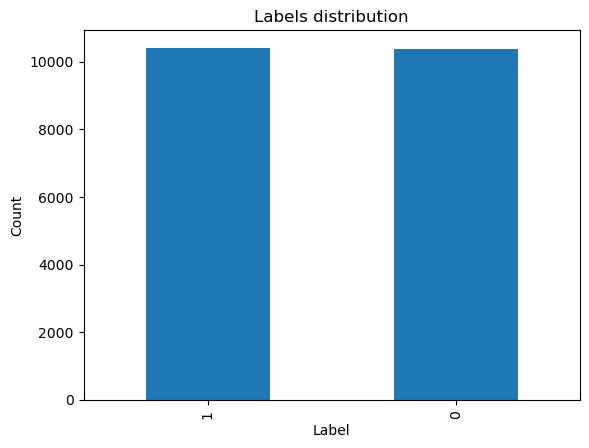

In [49]:
# Plot labels distribution
labels.plot(kind="bar")
plt.title("Labels distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Both labels seem to have similar representation within the dataset.

**Utterances (Sentences)**

When "utterances" is defined as number of sentences, we find ~45 sentences per article. This is likely a slight overestimate, as abbreviations (i.e, Sept., Mr. etc.) will improperly trigger a new sentence. 

In [50]:
df["utterances"] = (df["text"].str.count("\.") + df["text"].str.count("\? ")
                     + df["text"].str.count("\! ") + df["text"].str.count(
    "\! "))
avg = df["utterances"].mean()
print("Avg Utterances Per Article:", avg)

Avg Utterances Per Article: 44.771687298299696


When we use a package to split the text into utterances, it accounts for sentence structures such as punctuation and capitalization among other things. With the use of the nltk package, the average utterances in an article is approximately 35 per article. 

In [51]:
df['total_utterances'] = df['text'].astype(str).apply(lambda x: len(
    nltk.sent_tokenize(x)))
print('Average utterances (sentence length):', df['total_utterances'].mean())

Average utterances (sentence length): 35.12701923076923


On average, it seems that reliable news has more utterances. However, a comparison of the maximum utterances indicates that unreliable news has a higher range than articles classified as reliable news.

In [52]:
label_dist = df.groupby('label')['total_utterances'].agg(['mean', 'min', 'max'])
print(label_dist)

            mean  min   max
label                      
0      42.137287    1  1200
1      28.134255    0  1444


**Words in Text and Title**

In [53]:
df['word_count'] = df['text'].astype(str).apply(
    lambda x: len(re.findall(r'\w+', x)))
df['word_count_nltk'] = df['text'].astype(str).apply(
    lambda x: len(word_tokenize(x)))

print('Average article length:', df['word_count'].mean())
print('Total words in training dataset:', df['word_count'].sum())
print('Average article length using nltk:', df['word_count_nltk'].mean())

df['title_length'] = df['title'].astype(str).apply(
    lambda x: len(re.findall(r'\w+', x)))
print('Average title length:', df['title_length'].mean())

Average article length: 768.3626923076923
Total words in training dataset: 15981944
Average article length using nltk: 884.9644711538461
Average title length: 12.043365384615385


The above chunk of code looks at the total and average number of words in the text and title column of the dataset. To compute the average word length in the text column, we use regex and nltk packages and we get different answers using the different methods. The word_tokenize nltk package includes punctuation as tokens, thus increasing the word count and average word length. As a result, the regex method is a more accurate estimate of the number of words and average word length of text and title in the dataset. Using the regex method, the average word length of an article is approximately 768 words and the average title length is approximately 12 words.

When we check for words between both reliable and unreliable labels, we find the following:
1.  While words per reliable article have no articles with very few words, there is a large frequency of articles labelled as unreliable with very few words.
2. While the articles labelled reliable have a more balanced distribution, unreliable articles have a much longer skew and sharp drop off.

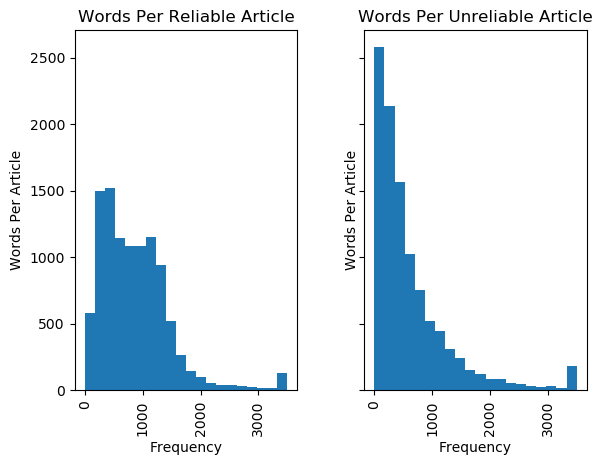

In [54]:
df['Length_bucket'] = df['word_count']
df.loc[df['word_count'] > 3500, 'Length_bucket'] = 3500 
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
df.hist(column='Length_bucket', by='label', bins=20, ax=axes)

axes[0].set_xlabel("Frequency")
axes[1].set_xlabel("Frequency")
axes[0].set_ylabel("Words Per Article")
axes[1].set_ylabel("Words Per Article")
axes[0].set_title("Words Per Reliable Article")
axes[1].set_title("Words Per Unreliable Article")

plt.show()

**Authors**

**Any authors with many articles?**
  
Yes (as shown in output) with some authors in the data seem to be placeholders or roles, not acutal author/source names. For example, we see the following authors in the data, all of which show up many times in the data:  

admin, Editor, Anonymous,-NO AUTHOR-, Guest, Author, Contributing Author. 


**Other Notable Author Anomalies**  

There are sometimes multiple authors for one text (i.e., "Patrick Healy, Jonathan Martin and Maggie Haberman ", Julie Hirschfeld Davis and Alan Rappeport, Julie Hirschfeld Davis and Charlie Savage)  
There are a few titles in author spots (i.e., "10 Shocking Facts About Society That We Absurdly Accept As Normal – Digital Flow")  
Sometimes, the same organization shows up in different spellings/ abbrevaitions (i.e., The Associated Press vs AP vs The Associated Press)  
There are many "blog usernames" (i.e., tokyowashi (noreply@blogger.com))  
There are occasionally incomplete names (i.e, "Michael" or "b")  
Some authors seem like they would write unreliable articles (i.e.,"Anonymous Coward (UID 11897093)  

In [55]:
df['author'].value_counts().nlargest(20)

Pam Key                243
admin                  193
Jerome Hudson          166
Charlie Spiering       141
John Hayward           140
Katherine Rodriguez    124
Warner Todd Huston     122
Ian Hanchett           119
Breitbart News         118
Daniel Nussbaum        112
AWR Hawkins            107
Jeff Poor              107
Joel B. Pollak         106
Trent Baker            102
Breitbart London        97
Bob Price               93
Ben Kew                 90
Charlie Nash            88
Pakalert                86
Eddy Lavine             85
Name: author, dtype: int64

When we check for the number of articles per author, we find that all articles of an author either tend to be marked as reliable or unreliable. For instance, there is one author with close to 250 reliable articles whereas another has 200 unreliable articles. Most authors follow this trend, with only a few have articles marked as both reliable and unreliable.

Text(0, 0.5, 'Number of Articles Per Author')

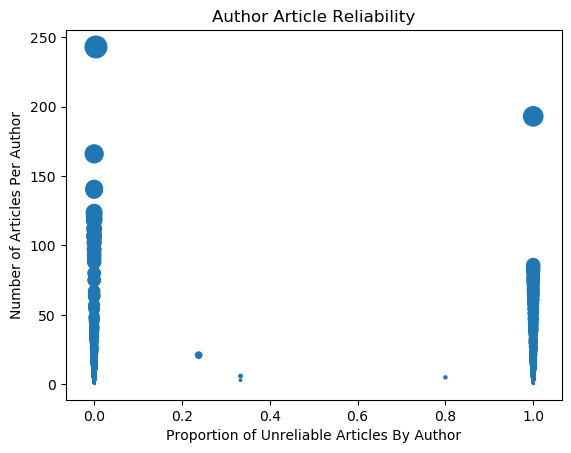

In [56]:
subset = df.loc[:,('author','label')].value_counts().reset_index(name='counts')

pivoted = subset.pivot(index='author', columns='label',
                        values='counts').reset_index()
pivoted.columns = ['author', 'label_0','label_1']
pivoted = pivoted.fillna(0)

pivoted['tot'] = pivoted['label_0'] + pivoted['label_1']
pivoted['label_0'] = pivoted['label_0'] / pivoted['tot']
pivoted['label_1'] = pivoted['label_1'] / pivoted['tot'] 

fig, ax = plt.subplots()
ax.scatter(pivoted['label_1'], pivoted['tot'], s = pivoted['tot'])

plt.title("Author Article Reliability")
plt.xlabel("Proportion of Unreliable Articles By Author")
plt.ylabel("Number of Articles Per Author")

**Investigating NAN author trends**

We find null authors are mostly labelled unreliable, and therefore observations with no author listed are generally are unreliable. When we check for nulls with authors, we find that it is almost always that when an author is a null value, the article is labelled as unreliable.

In [57]:
df['author_bool'] = np.where(df.loc[:,'author'].isnull(),0,1)

#browse null authors 
print(df.loc[(df.loc[:,'author_bool'] == 0),:].head())

print(df.groupby(['author_bool','label']).count().loc[:,['id']])

    id                                              title author  \
6    6  Life: Life Of Luxury: Elton John’s 6 Favorite ...    NaN   
8    8  Excerpts From a Draft Script for Donald Trump’...    NaN   
20  20  News: Hope For The GOP: A Nude Paul Ryan Has J...    NaN   
23  23  Massachusetts Cop’s Wife Busted for Pinning Fa...    NaN   
31  31  Israel is Becoming Pivotal to China’s Mid-East...    NaN   

                                                 text  label  utterances  \
6   Ever wonder how Britain’s most iconic pop pian...      1        24.0   
8   Donald J. Trump is scheduled to make a highly ...      0        79.0   
20  Email \nSince Donald Trump entered the electio...      1        16.0   
23  Massachusetts Cop’s Wife Busted for Pinning Fa...      1        25.0   
31  Country: Israel While China is silently playin...      1        40.0   

    total_utterances  word_count  word_count_nltk  title_length  \
6                 25         512              562            18   


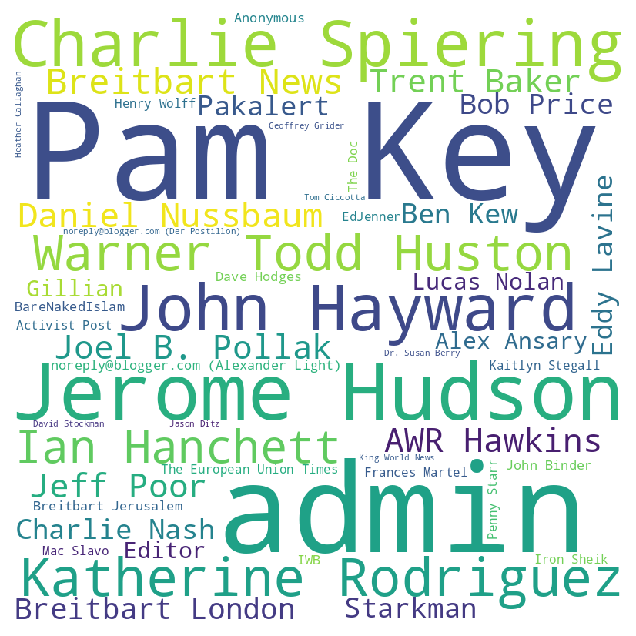

In [58]:
import wordcloud as wc
freq = df['author'].value_counts().nlargest(50)
df_freq = pd.DataFrame({'name': freq.index, 'frequency': freq.values})
dict_freq = dict(zip(df_freq['name'].tolist(), df_freq['frequency'].tolist()))
wordcloud = wc.WordCloud(width=800, height=800, background_color='white'
                         ).generate_from_frequencies(dict_freq)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The wordcloud above showcases the 50 most frequent authors.

**Nulls Across Dataset**

Any null values in the text column are removed whereas nulls in the author column are replaced with 'Unknown'

In [59]:
print("Checking for nulls:")
print(df.isnull().any())

df = df.dropna(subset=['text'])
df = df.fillna('Unknown')

print("Re-checking for nulls:")
print(df.isnull().any())
df = df.reset_index(drop=True)

Checking for nulls:
id                  False
title                True
author               True
text                 True
label               False
utterances           True
total_utterances    False
word_count          False
word_count_nltk     False
title_length        False
Length_bucket       False
author_bool         False
dtype: bool
Re-checking for nulls:
id                  False
title               False
author              False
text                False
label               False
utterances          False
total_utterances    False
word_count          False
word_count_nltk     False
title_length        False
Length_bucket       False
author_bool         False
dtype: bool


### Pre-Processing

For preprocessing the text, we initially remove text in any other languages other than English. 

In [60]:
# removing text in languages other than English

def detect_lang(text):
    '''
    This function removes any text in the data that is not in the English language.

    Input (df): dataframe with textual data
    Output: dataframe with data only in the English language
    '''
    try:
        lang = detect(text)
    except:
        lang = None
    return lang

df['language'] = df['text'].apply(detect_lang)

# filtering rows where language is not 'en'
df = df[df['language'] == 'en']

df = df.drop(columns=['language'])
df = df.reset_index(drop=True)

We then remove the title from the text if it is present.

In [61]:
#Removing title from text if it is present
for i, title in enumerate(df['title']):
    if title in df.loc[i, 'text']:
        df['text'] = df['text'].str.replace(title, '', regex=False)

For text preprocessing, we first load stop words and initialize the stemmer and lemmatizer to be used. 

In [62]:
# Load the stop words
stop_words = set(stopwords.words('english'))

# Initialize the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

We next write a function to conduct text processing, in specific, removing urls, punctuation, lowercasing the text, converts numbers to text, tokenizes and removes stop words, and stems and lemmatizes the words. 


In [63]:
def preprocess_text(data):
    '''
    Function to conduct text preprocessing, in specific, removing urls, 
    punctuation, lowercasing the text, converts numbers to text, tokenizes
    and removes stop words, and stems and lemmatizes the words. 

    Inputs:
        text (str): A string of text
    
    Outputs:
        processed text (str): A string of processed text
    '''
    
    #removing url related data
    data = re.sub(r'https?:\/\/\S+', '', data)

    #removing punctuation
    data = re.sub(r'[\.\?\!\,\:\;\(\)\\\$\*\@\&\#\'"]', '', data)
    
    #removing white space
    data = re.sub(r'\s+', ' ', data).strip()

    # lowercasing
    data = data.lower()

    #converting numbers to text
    p = inflect.engine()
    convert_to_words = lambda x: p.number_to_words(int(x.group())) if int(x.group()) < 1e18 else x.group()
    data = re.sub(r'\d+', convert_to_words, data)
    
    # creating tokens
    data = nltk.word_tokenize(data)
    
    # remove stopwords
    data = [ele for ele in data if ele not in stop_words]
    
    # stemming
    data = [stemmer.stem(ele) for ele in data]
    
    # lemmatizing
    data = [lemmatizer.lemmatize(ele) for ele in data]
    
    prep_data = ' '.join(data)

    return prep_data

In [64]:
# preprocessing to get tokens for text
df['clean_text'] = df['text'].apply(preprocess_text)
df['clean_title'] = df['title'].apply(preprocess_text)

In [68]:
print("Data after preprocessing")
df.loc[:, ['clean_text', 'clean_title']].head()

Data after preprocessing


,clean_text,clean_title
0,darrel lucu octob thirti two thousand sixteen ...,hous dem aid ’ even see comey ’ letter jason c...
1,ever get feel life circl roundabout rather hea...,flynn hillari clinton big woman campu - breitbart
2,octob twenty-nin two thousand sixteen tension ...,truth might get fire
3,video rate civilian kill american airstrik afg...,fifteen civilian kill singl u airstrik identifi
4,print iranian woman sentenc six year prison ir...,iranian woman jail fiction unpublish stori wom...


In [65]:
# counting words
def count_words(data):
    """
    This function counts the words from textual data present in a column across all the rows.
    
    Input:
    data (str): textual article data
    
    Output:
    Total and unique count of words across all rows of data 
    """
    
    #separate words based on word boundary
    all_words = data.str.findall(r'\b\w[\w\'\-]*\b')
    all_words = all_words.explode()
    
    #find total words in the data set
    print(f'Total words in the column {len(all_words)}')

    #find unique words in the data set
    unique_words = all_words.value_counts()
    print(f'Unique words in the column {len(unique_words)}')

print("Before preprocessing for 'text'")
count_words(df['text'])

print("After preprocessing for 'text'")
count_words(df['clean_text'])

print("Before preprocessing for 'title'")
count_words(df['title'])

print("After preprocessing for 'title'")
count_words(df['clean_title'])

Before preprocessing for 'text'
Total words in the column 15628451
Unique words in the column 179555
After preprocessing for 'text'
Total words in the column 8855335
Unique words in the column 113436
Before preprocessing for 'title'
Total words in the column 241326
Unique words in the column 26770
After preprocessing for 'title'
Total words in the column 173931
Unique words in the column 15170


After data cleaning and preprocessing we reduced the total number of words in the text column from 15,628,441 to 8,855,328 words and reduced the number of unique words from 179,553 to 113,434 words.

In terms of next steps, we have also prepared a function to create a list of tokens of “n” length.  We plan to use this function to test the machine learning algorithm with single word tokens and compare the accuracy to running the model with all two-word, three-word, etc. combinations of words that appear in the text.

In [66]:
def compute_n_grams(dataframe_col, n):
    '''
    Compute n-words combinations given a df column with text

    Inputs:
        dataframe_col: a pandas df column with text
        n: interger of desired gram length gram linteger indicating the length of desired gram combinations

    Returns: list of list of n-grams tuples
    '''
    split = dataframe_col.str.split()

    gram_list_of_lists = []
    for row in split:
        gram_list = []
    
        # Creating and compiling n-grams
        for i in range(len(row)-n+1):
            gram_list.append(tuple(row[i:i+n]))

        gram_list_of_lists.append(gram_list)
        
    return gram_list_of_lists

#0-1 to limit to the first row
ngrams = compute_n_grams(df['text'][0:1],3)
print(ngrams)

[[('By', 'Darrell', 'Lucus'), ('Darrell', 'Lucus', 'on'), ('Lucus', 'on', 'October'), ('on', 'October', '30,'), ('October', '30,', '2016'), ('30,', '2016', 'Subscribe'), ('2016', 'Subscribe', 'Jason'), ('Subscribe', 'Jason', 'Chaffetz'), ('Jason', 'Chaffetz', 'on'), ('Chaffetz', 'on', 'the'), ('on', 'the', 'stump'), ('the', 'stump', 'in'), ('stump', 'in', 'American'), ('in', 'American', 'Fork,'), ('American', 'Fork,', 'Utah'), ('Fork,', 'Utah', '('), ('Utah', '(', 'image'), ('(', 'image', 'courtesy'), ('image', 'courtesy', 'Michael'), ('courtesy', 'Michael', 'Jolley,'), ('Michael', 'Jolley,', 'available'), ('Jolley,', 'available', 'under'), ('available', 'under', 'a'), ('under', 'a', 'Creative'), ('a', 'Creative', 'Commons-BY'), ('Creative', 'Commons-BY', 'license)'), ('Commons-BY', 'license)', 'With'), ('license)', 'With', 'apologies'), ('With', 'apologies', 'to'), ('apologies', 'to', 'Keith'), ('to', 'Keith', 'Olbermann,'), ('Keith', 'Olbermann,', 'there'), ('Olbermann,', 'there', 'i